In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u

import scanning
import scanning.visualization as vis

# Simulation

## Hitmaps

Creating a `Simulation` object works by passing a `TelescopePattern` object, which stores the AZ/EL coordinates of the telescope boresight. By passing an `Instrument` object and the name of one of its modules, we use the detector element positions of that camera module and use the coordinates of the scan pattern that that camera module would make. 

TO ADD: Bin line plots

In [2]:
# create an Instrument with a Module
prime_cam = scanning.PrimeCam()
prime_cam.add_module('Mod280', 'i1')

# create a SkyPattern 
daisy = scanning.Daisy(velocity=1/3, start_acc=0.2, R0=0.47, Rt=800*u.arcsec, Ra=600*u.arcsec, T=186, sample_interval=1/400)

# set an observation for TelescopePattern (needed to get field rotation)
daisy_T = scanning.TelescopePattern(daisy, prime_cam, data_loc='Mod280', start_ra=40, start_dec=-60, start_hrang=0)

Generating histograms for kept hits...
...0/40035 completed...
total number of hits 207541440 == 207541440.0
Generating histograms for removed hits...
...0/34365 completed...
total number of hits 178148160 == 178148160.0


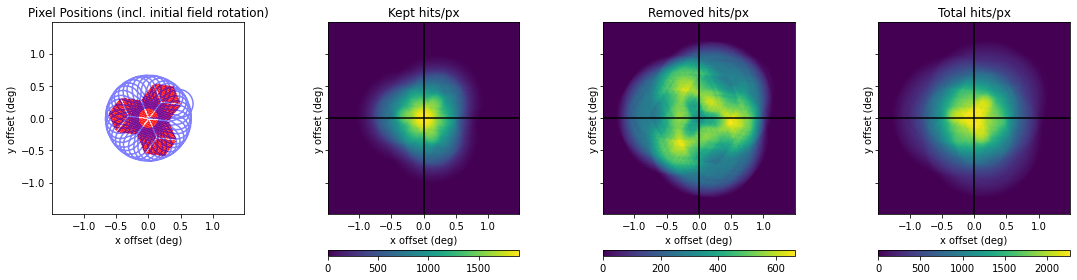

In [3]:
# pass the AZ/EL coordinates of the telescope boresight as well as the instrument and its desired module
sim1 = scanning.Simulation(
    daisy_T, prime_cam, 'Mod280', 
    pixel_size=10*u.arcsec,             # this is the default, but is shown here explicity 
    max_acc=0.25*u.deg/u.s/u.s          # filter out samples above an acceleration of 0.25 deg/s^2
)

# show hitmap (note that simulating will be run once (for kept and removed hits each) when first called, and then stored)
vis.hitmap(sim1, convolve=True, norm_time=False, kept_hits=True, removed_hits=True, total_hits=True) # by default kept_hits is only True

---
Filter out detectors in many different ways. You can combine any of these parameters together, but only detector elements that satisfy ALL will remain. See documentation for more details of implementation. 

Generating histograms for kept hits...
...0/5867 completed...
total number of hits 3379392 == 3379392.0


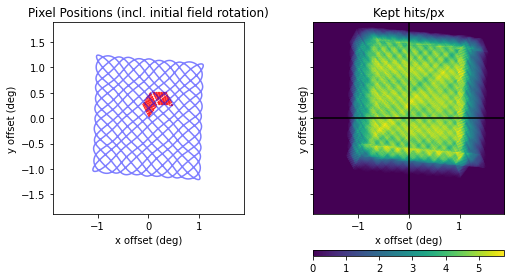

Generating histograms for kept hits...
...0/5867 completed...
total number of hits 6441966 == 6441966.0


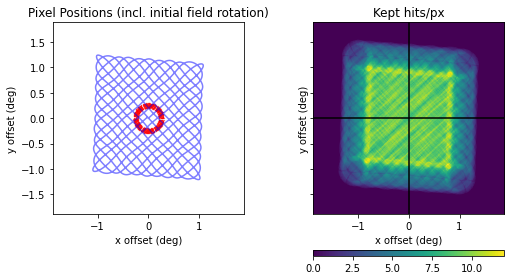

Generating histograms for kept hits...
...0/5867 completed...
total number of hits 11734 == 11734.0


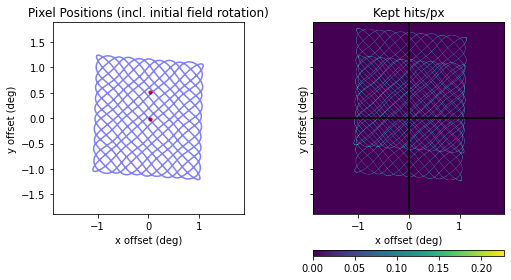

          x         y  pol  rhombus  wafer  pixel_num
0  0.339633  0.000000    0        0      0          0
1  0.345768  0.010625   45        0      0          1
Generating histograms for kept hits...
...0/5867 completed...
total number of hits 5867 == 5867.0


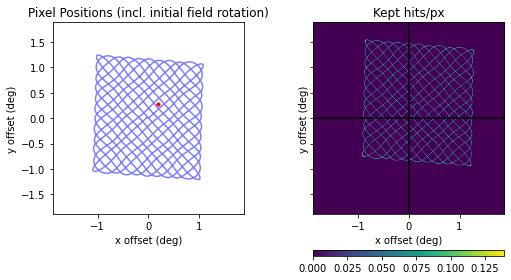

Generating histograms for kept hits...
...0/5867 completed...
total number of hits 6101680 == 6101680.0


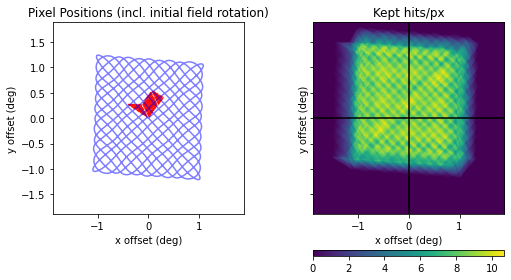

In [4]:
# let's make a Pong pattern centered at the boresight (at a lower sample interval since there's a lot)
# but let's see what the hitmap would look like for an offset module
pong = scanning.Pong(num_term=4, width=2, height=2, spacing='500 arcsec', velocity=1/2, sample_interval=1/40)
pong_T = scanning.TelescopePattern(pong, start_ra=40, start_dec=-60, start_hrang=0)

# polarizations, rhombuses, wafers
sim2 = scanning.Simulation(
    pong_T, prime_cam, 'Mod280',
    pols_on=[0, 15], wafers_on=[0], 
    # rhombi_on=1
)
vis.hitmap(sim2) 

# detector elements falling inside a radius range
sim2 = scanning.Simulation(
    pong_T, prime_cam, 'Mod280',
    min_speed=0.1, # combine with min_speed/max_speed
    det_radius=[0.2*u.deg, 0.3*u.deg] 
)
vis.hitmap(sim2)

# a list of (x, y) positions to keep on the detector element closest to each position
sim2 = scanning.Simulation(
    pong_T, prime_cam, 'Mod280',
    det_list=[(0, 0), (1800, 1800)] # parameters requiring precise measurements are by default in arcseconds
)
vis.hitmap(sim2)

# a list of detector numbers "pixel_num" to keep on exact detector elements.
print(scanning.Mod280._data.head(2))
sim2 = scanning.Simulation(
    pong_T, prime_cam, 'Mod280',
    det_list=[0]
)
vis.hitmap(sim2)

# take the [(x_min, x_max), (y_min, y_max)] range of detector elements to keep
# note that the initial field rotation is applied to the left image, so that's why it's tilted
sim2 = scanning.Simulation(
    pong_T, prime_cam, 'Mod280',
    det_lim=[(0, 1800), (0, 1800)]
)
vis.hitmap(sim2)

---
You can save a copy or return of the 2D array hitmap. 

In [5]:
# get returned a 2D array and bin edges
sim1_hitmap, sim1_bin = sim1.sky_histogram(hits='kept', convolve=True, norm_time=False)
print('bins =', sim1_bin)
print('hitmap =', sim1_hitmap)

# pass a file into path_or_buf to get a csv file, with the columns and index representing bin edges
sim1.sky_histogram(hits='kept', convolve=False, norm_time=True, path_or_buf='daisy_hitmap.csv')
pd.read_csv('daisy_hitmap.csv', index_col=0, header=0).head()

bins = [-1.48611111 -1.48333333 -1.48055556 ...  1.47777778  1.48055556
  1.48333333] deg
hitmap = [[-6.06944296e-14  4.47280928e-14 -3.26213778e-14 ...  1.10852755e-13
   4.12511137e-14 -1.08421844e-13]
 [-7.89612180e-14  2.60458878e-14 -5.07841319e-14 ...  9.33015444e-14
   2.39970844e-14 -1.26745269e-13]
 [-9.49461095e-14  9.78306675e-15 -6.65028273e-14 ...  7.72241751e-14
   8.18771255e-15 -1.43537992e-13]
 ...
 [-1.03290143e-13  1.01691591e-14 -7.42284510e-14 ...  6.58874913e-14
   1.24283097e-15 -1.39422898e-13]
 [-1.21070536e-13 -7.51342861e-15 -9.13875129e-14 ...  4.74998263e-14
  -1.71141694e-14 -1.57807287e-13]
 [-1.35531030e-13 -2.22843702e-14 -1.05890059e-13 ...  3.28043987e-14
  -3.24741646e-14 -1.73803543e-13]]


,-1.4861111111111112,-1.4833333333333334,-1.4805555555555556,-1.4777777777777779,-1.475,-1.4722222222222223,-1.4694444444444446,-1.4666666666666668,-1.463888888888889,-1.4611111111111112,...,1.4583333333333335,1.4611111111111112,1.463888888888889,1.4666666666666668,1.4694444444444446,1.4722222222222223,1.475,1.4777777777777779,1.4805555555555556,1.4833333333333334
-1.486111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1.483333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1.480556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1.477778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1.475000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Sky-Pixel Analysis

Specify pixel(s) in the x-y offset plane to focus on. You can get a histogram of which detector elements hit that region and how many times, as well as a histogram of the number of hits on that region per timestamp. 

In [6]:
sim3 = scanning.Simulation(
    daisy_T, prime_cam, 'Mod280', 
    pxan_lim=[(-30, 30), (-30, 30)], # a 6 by 6 pixel region on the center
    # pxan_list=[(0,0)]
    max_acc=0.25 # combine with other parameters like detector filters and sample filters
)

Generating histograms for kept hits...
...0/40035 completed...
total number of hits 207541440 == 207541440.0


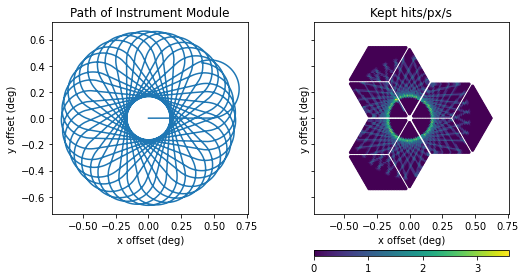

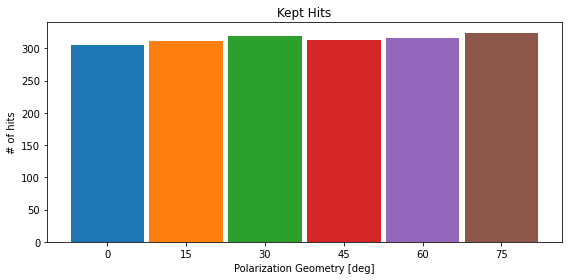

detector pixel # = [   0    1    2 ... 5181 5182 5183]
detector histogam = [0.55555556 0.58333333 0.22222222 ... 0.         0.         0.        ]


In [7]:
# get a hitmap of which detector elements hit that region and how many times
vis.pxan_detector(sim3, norm_pxan=True, norm_time=False) # norm_pxan: whether to average the hits by dividing the total hits by the number of pixels. 

# get a histogram of how many times each detector element, grouped by their initial pixel positions, hit that region
vis.pxan_polarization(sim3, norm_pxan=True, norm_time=False)

# return this detector histogram
# note that NaN values are used for detectors that have been filtered out
det_hist, det_pixel_num = sim3.det_histogram('kept', path=None, norm_pxan=True, norm_time=False)
print('detector pixel # =', det_pixel_num)
print('detector histogam =', det_hist)

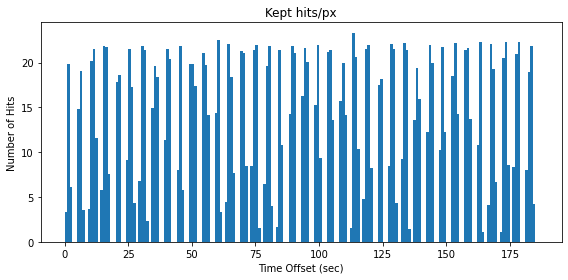

time offsets = [0.000000e+00 2.500000e-03 5.000000e-03 ... 1.859925e+02 1.859950e+02
 1.859975e+02]
time_hist = [ 0.  0.  0. ... nan nan nan]


In [8]:
# get a histogram of the number of hits on the region per timestamp
vis.pxan_time(sim3, bin=1*u.s, norm_pxan=True, norm_time=False)

# return this time histogram
# note that NaN values are used for samples that have been filtered out
time_hist, time_offsets = sim3.time_histogram('kept', path=None, norm_pxan=True, norm_time=False)
print('time offsets =', time_offsets)
print('time_hist =', time_hist)

## Polarization

Get a histogram of which polarization geometries have been captured. 

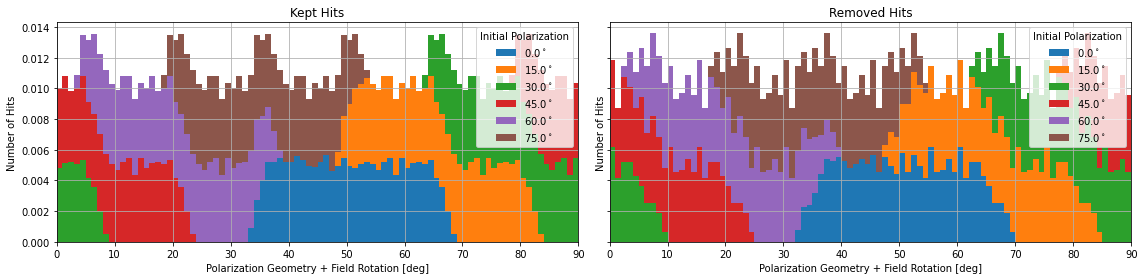

In [9]:
# let's use a longer scan
pong2 = scanning.Pong(num_term=4, width=2, height=2, spacing='400 arcsec', velocity=1/2, sample_interval=1, num_repeat=20)
telescope_pattern2 = scanning.TelescopePattern(pong2, instrument=prime_cam, data_loc='Mod280', start_ra=0, start_dec=0, start_hrang=0)

sim4 = scanning.Simulation(telescope_pattern2, prime_cam, 'Mod280', max_acc=0.25)
vis.polarization_histogram(sim4, stacked=True, removed_hits=True)

In [10]:
# return this
pol, initial_counts = sim4.pol_histogram('kept', path=None)

print('field rotation + detector geometry at each sample =')
print(pol)
print('number of detectors per geometry =', initial_counts)

field rotation + detector geometry at each sample =
           0.0        15.0       30.0       45.0       60.0       75.0
0     67.014361  82.014361   7.014361  22.014361  37.014361  52.014361
1     67.479525  82.479525   7.479525  22.479525  37.479525  52.479525
2     67.898938  82.898938   7.898938  22.898938  37.898938  52.898938
3     67.167109  82.167109   7.167109  22.167109  37.167109  52.167109
4     66.709655  81.709655   6.709655  21.709655  36.709655  51.709655
...         ...        ...        ...        ...        ...        ...
1910  35.355303  50.355303  65.355303  80.355303   5.355303  20.355303
1911  34.525966  49.525966  64.525966  79.525966   4.525966  19.525966
1912  33.649302  48.649302  63.649302  78.649302   3.649302  18.649302
1913  33.387345  48.387345  63.387345  78.387345   3.387345  18.387345
1914  34.216224  49.216224  64.216224  79.216224   4.216224  19.216224

[1915 rows x 6 columns]
number of detectors per geometry = [864 864 864 864 864 864]
